In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import random
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import timedelta
from pickle import dump

Bunch Load

In [2]:
#Initial order of the variables in the dataset
VarOfInterest_Init = {'RankOneLeafDate': 0, 'AppearedSpatheDate_compl': 1, 
                      'OpenedSpatheDate_compl': 2, 'FloweringDate_compl': 3, 
                      'HarvestDate_compl': 4, 'BunchMass': 5, 
                      'FemaleInflo': 6, 'MaleInflo': 7, 
                      'AbortedInflo': 8, 'BunchLoad': 9}

In [3]:
def change_nan_to_z(data):
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    # Check if the data contains only numeric values
    if not np.issubdtype(data.dtype, np.number):
        raise TypeError(f"Data contains non-numeric values: {data.dtype}")

    # Convert NaNs to zeros if any exist
    if np.isnan(data).any():
        data = np.nan_to_num(data)
        
    return data

In [4]:
def load_data():
        # Get the current working directory
    current_dir = os.getcwd()

    # Get the parent directory
    parent_dir = os.path.dirname(current_dir)

    print("Current working directory:", current_dir)
    print("Parent directory:", parent_dir)

    folder_path = os.path.join(parent_dir,'dataCIGE')
    
    Pheno_origin = np.load(folder_path + '/phenoExportFinal/Events_tree_SMSE_Charge.npy', allow_pickle=True)
    Pheno_timeframe = np.array(Pheno_origin[:,:,-1])
    Pheno_INPUT  = np.array(Pheno_origin[:,:,:-1], dtype= np.float32)
    Pheno_INPUT = change_nan_to_z(Pheno_INPUT)

    Meteo_origin = np.load(folder_path + '/phenoExportFinal/dfMeteoInfo.pkl', allow_pickle=True)

    # Get the column names of the DataFrame
    MeteoVarOfInterest_Init = list(Meteo_origin.columns)
    print(MeteoVarOfInterest_Init)

    MeteoVarOfInterest_Init = MeteoVarOfInterest_Init[1:]
    pheno_min_dt = pd.to_datetime(Pheno_timeframe.reshape(-1)).min()
    pheno_max_dt = pd.to_datetime(Pheno_timeframe.reshape(-1)).max()

    
    Meteo_origin = Meteo_origin[Meteo_origin['SiteName'] == 'SMSE']
    print(Meteo_origin.iloc[:,0].unique())
    Meteo_origin['ObservationDate'] = pd.to_datetime(Meteo_origin['ObservationDate'])
    Meteo_origin = np.array(Meteo_origin[(Meteo_origin['ObservationDate'] >= pheno_min_dt) & (Meteo_origin['ObservationDate'] <= pheno_max_dt)].values[:,2:], dtype= np.float32)
    Meteo_INPUT = change_nan_to_z(Meteo_origin)

    """# Plot each variable
    for i in range(Meteo_origin.shape[1]):
        plt.plot(Meteo_origin[1000:2000,i], c='b')
        plt.title(MeteoVarOfInterest_Init[i])
        plt.show()
    """
    if Pheno_origin.shape[1] == Meteo_origin.shape[0]:
        str_out = f'Import of the Data\nThe number of days {Meteo_origin.shape[0]} in the phenology and meteo data is the same'
        print(str_out.upper())
    if type(Pheno_origin) == type(Meteo_origin):
        str_out = f'The phenology and meteo data have the same data type {type(Pheno_origin)}\n\n'
        print(str_out.upper())

    if np.isnan(Pheno_INPUT).any() == False and np.isnan(Meteo_INPUT).any() == False:
        str_out = f'The phenology and meteo data do not contain any NaN values\n\n'
        print(str_out.upper())
    return Pheno_INPUT, Meteo_INPUT, MeteoVarOfInterest_Init


In [5]:
Pheno_INPUT, Meteo_origin, MeteoVarOfInterest_Init  = load_data()
print(Meteo_origin.shape)

Current working directory: /home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs
Parent directory: /home/u108-n256/PalmProject/NeuralNetwork_Testing


FileNotFoundError: [Errno 2] No such file or directory: '/home/u108-n256/PalmProject/NeuralNetwork_Testing/dataCIGE/phenoExportFinal/Events_tree_SMSE_Charge.npy'

In [ ]:
def reduce_to_20(Pheno_origin: np.array) -> np.array:
    """
    Reduces the input 3D array along its second dimension in chunks of 40.
    For each chunk of 40 days, it computes the sum of all features except the 
    feature at index 9, for which it computes the mean.

    Parameters:
    Pheno_origin (np.array): A 3D numpy array where the dimensions are 
                             (number of trees, number of days, number of features).

    Returns:
    np.array: A 3D numpy array reduced along the second dimension.
    """
    # Calculate the shape of the new array: (number of trees, number of 40-day periods, number of features)
    # Data  = trees x 40-day periods x features
    Data = np.empty((int(Pheno_origin.shape[0]), int(Pheno_origin.shape[1] / 20)+1, int(Pheno_origin.shape[2])))
    # Iterate over each tree
    for tree in range(Pheno_origin.shape[0]):
        # Iterate over each 30-day period
        for i, days in enumerate(range(0, Pheno_origin.shape[1], 20)):
            # Iterate over each feature
            for feature in range(Pheno_origin.shape[2]):
                if feature != 9:
                    # Sum the feature values over the 40-day period
                    Data[tree, i, feature] = np.sum(Pheno_origin[tree, days:days+20, feature], axis=0)
            
                else:
                    # Compute the mean for the feature at index 9 over the 40-day period
                    chunk = np.sum(Pheno_origin[tree, days:days+20, feature], axis=0)
                    Data[tree, i, feature] = chunk / 20 
    str_out = f'1. Time reduction \n Input Data: {Pheno_origin.shape}\n\nOutput Data: {Data.shape}\n\n'
    male_MA_flowers = np.zeros((Data.shape[1], 1))
    female_MA_flowers = np.zeros((Data.shape[1], 1))
    aborted_MA_flowers = np.zeros((Data.shape[1], 1))
    for tree in range(Data.shape[0]):
        for period_20_days in range(Data.shape[1]):
            if period_20_days == 0:
                ma_f = np.sum(Data[tree, period_20_days:period_20_days+2, 6], axis=0)
                ma_m = np.sum(Data[tree, period_20_days:period_20_days+2, 7], axis=0)
                ma_a = np.sum(Data[tree, period_20_days:period_20_days+2, 8], axis=0)
            elif period_20_days == Data.shape[1]-1:
                ma_f = np.sum(Data[tree, period_20_days-1:period_20_days, 6], axis=0)
                ma_m = np.sum(Data[tree, period_20_days-1:period_20_days, 7], axis=0)
                ma_a = np.sum(Data[tree, period_20_days-1:period_20_days, 8], axis=0)
            else:
                ma_f = np.sum(Data[tree, period_20_days-1:period_20_days+2, 6], axis=0)
                ma_m = np.sum(Data[tree, period_20_days-1:period_20_days+2, 7], axis=0)
                ma_a = np.sum(Data[tree, period_20_days-1:period_20_days+2, 8], axis=0)
            
            female_MA_flowers[period_20_days,:] = ma_f
            male_MA_flowers[period_20_days,:] = ma_m
            aborted_MA_flowers[period_20_days,:] = ma_a
        Data[tree,:,6] = female_MA_flowers.reshape(-1)
        Data[tree,:,7] = male_MA_flowers.reshape(-1)
        Data[tree,:,8] = aborted_MA_flowers.reshape(-1)

    print(str_out.upper())    
    print(Data[0,:,6])  
    return Data


In [ ]:
"""@njit
def create_samples_array(Data : np.array) -> np.array:
    # Create samples of 45 x 20 days = 900 every 5 days
    # prediction time 2 x 20 = 40 days, gap 8 x 20 = 160 days and 35 x 20 = 700 days
    Data_samples = np.empty(0, 45, Data.shape[2])
    for tree in range(Data.shape[0]):
        for i in range(0,Data.shape[1]-45):
            data =  Data[tree,i:i+45,:]
            data  = data[np.newaxis,:,:]
            Data_samples = np.concatenate((Data_samples, data), axis=int(0))
    str_out = f'The data were transformed into samples.\nThe shape of the new array is {Data_samples.shape}'
    print(str_out.upper())
    return Data_samples
"""

"@njit\ndef create_samples_array(Data : np.array) -> np.array:\n    # Create samples of 45 x 20 days = 900 every 5 days\n    # prediction time 2 x 20 = 40 days, gap 8 x 20 = 160 days and 35 x 20 = 700 days\n    Data_samples = np.empty(0, 45, Data.shape[2])\n    for tree in range(Data.shape[0]):\n        for i in range(0,Data.shape[1]-45):\n            data =  Data[tree,i:i+45,:]\n            data  = data[np.newaxis,:,:]\n            Data_samples = np.concatenate((Data_samples, data), axis=int(0))\n    str_out = f'The data were transformed into samples.\nThe shape of the new array is {Data_samples.shape}'\n    print(str_out.upper())\n    return Data_samples\n"

In [ ]:
def create_samples_array(Data: np.array) -> np.array:
    # Create samples of 45 x 20 days = 900 days in total, every 5 days
    # prediction time 2 x 20 = 40 days, gap 8 x 20 = 160 days and 35 x 20 = 700 days
    # (trees = 266 x months to use (175-45), days = 45, features = 10) --> Data_samples

    # Initialize an empty array to hold the samples
    # The shape of Data_samples is (number of samples, 45 days, number of features)
    Data_samples = np.empty((Data.shape[0] * (Data.shape[1] - 50), 50, Data.shape[2]))
    
    # Initialize a counter for the sample index
    sample_idx = 0
    
    # Loop through each "tree" in the Data array
    for tree in range(Data.shape[0]):
        # For each tree, loop through the time steps, creating samples of 45 days
        for i in range(0, (Data.shape[1] - 50)):
            # Extract a sample of 45 days and assign it to the appropriate position in Data_samples
            Data_samples[sample_idx] = Data[tree, i:i + 50, :]
            # Increment the sample index
            sample_idx += 1
    
    Data_samples = Data_samples.reshape(Data.shape[0], Data.shape[1]-50, 50, Data.shape[2])
    # Print the shape of the resulting array and additional information
    str_out = f'2. Sampling Phenological Data \nInput Data: {Data.shape}\n\nOutput Data: {Data_samples.shape}\n\n'
    print(str_out.upper())

    # Return the array of samples
    return Data_samples


In [ ]:
def MinMax_Data(Data: np.array, id_target_feature: list) -> np.array:
    '''
    Data : np.array
        Data to be scaled

    id_target_feature : int
        Index of the target feature in the Data array

    !!!! The target feature should be the last feature in the Output Data array after the scaling !!!!
    '''
    
    # Save the original shape of the data
    Data_shape = Data.shape
    
    # Initialize MinMax scalers for the features (X) and the target (y)
    MinMax_Scaler_X = MinMaxScaler()
    MinMax_Scaler_y_female = MinMaxScaler()
    MinMax_Scaler_y_male = MinMaxScaler()
    MinMax_Scaler_y_aborted = MinMaxScaler()
    
    # Reshape Data to 2D array where each row is a sample and each column is a feature
    Data = Data.reshape(-1, Data_shape[2])
    

    # Separate the features (Data_X) by removing the target feature column
    Data_X = np.delete(Data, id_target_feature[:-1], axis=1)
    # Scale the features using MinMaxScaler
    Data_X = MinMax_Scaler_X.fit_transform(Data_X.reshape(-1, Data_X.shape[1]))
    

    # Extract the target feature column (Data_y)
    Data_y_f = Data[:, id_target_feature[0]]
    # Scale the target feature using MinMaxScaler
    Data_y_f = MinMax_Scaler_y_female.fit_transform(Data_y_f.reshape(-1, 1))


    # Extract the target feature column (Data_y)
    Data_y_m = Data[:, id_target_feature[1]]
    # Scale the target feature using MinMaxScaler
    Data_y_m = MinMax_Scaler_y_male.fit_transform(Data_y_m.reshape(-1, 1))

    # Extract the target feature column (Data_y)
    Data_y_a = Data[:, id_target_feature[2]].copy()
    # Scale the target feature using MinMaxScaler
    Data_y_a = MinMax_Scaler_y_aborted.fit_transform(Data_y_a.reshape(-1, 1))
    
    # Concatenate the scaled features and the scaled target feature back together
    Data = np.concatenate((Data_X, Data_y_f, Data_y_m), axis=1)
    
    # Reshape the data back to its original shape
    Data_ = Data.reshape(Data_shape)
    
    # Print the shape of the scaled data
    str_out = f'3. Normalization Phenological Data \nInput Data: {Data_shape}\n\nOutput Data: {Data_.shape}\n\n'  
    print(str_out.upper())

    dump(MinMax_Scaler_X, open('MinMax_Scaler_X.pkl', 'wb'))
    dump(MinMax_Scaler_y_female, open('MinMax_Scaler_y_F.pkl', 'wb'))
    dump(MinMax_Scaler_y_male, open('MinMax_Scaler_y_M.pkl', 'wb'))
    dump(MinMax_Scaler_y_aborted, open('MinMax_Scaler_y_A.pkl', 'wb'))
    # Return the scaled data and the scalers for the target feature and the features
    return Data_

In [ ]:
def split_meteo_to_samples(Meteo_origin: np.array) -> np.array:
    # Calculate the maximum number of usable days that can be divided evenly into 20-day periods
    useable_days = int(Meteo_origin.shape[0] / 20) * 20
    
    # Initialize an empty array to hold the samples
    # Each sample consists of 900 days of data
    # The shape of Meteo_samples is (number of samples, 900, number of features)
    Meteo_samples = np.zeros((int((useable_days - 1000) / 20) + 1, 1000, Meteo_origin.shape[1]))
    
    # Loop through the Meteo_origin array, creating samples of 900 consecutive days,
    # starting every 20 days
    for sample_idx, i in enumerate(range(0, (useable_days - 1000) + 1, 20)):
        # Extract a sample of 900 days and assign it to the appropriate position in Meteo_samples (0-900, 20-920, 40-940, ...)
        Meteo_samples[sample_idx,:,:] = Meteo_origin[i:i + 1000, :]

    Meteo_samples = np.repeat(np.expand_dims(Meteo_samples, axis=0), 266,axis=0)
    
    # Print the shape of the resulting array
    str_out = f'4. Sampling Meteorological Data \nInput Data: {Meteo_origin.shape}\n\nOutput Data: {Meteo_samples.shape}\n\n'  
    print(str_out.upper())
    
    # Return the array of samples
    return Meteo_samples

In [ ]:
def days_to_features(X: np.array) -> np.array:
    if len(X.shape) == 4:
        transposed_array = np.empty((X.shape[0],X.shape[1],40,180))
        for tree in range(X.shape[0]):
            tree_array = np.empty((X.shape[1],40,180))
            for sample in range(X.shape[1]):
                sample_tensor = np.empty((40,180))
                for i, day in enumerate(range(0,X.shape[2],20)):
                    new_day = X[tree, sample, day:day+20, :]
                    sample_tensor[i,:] = new_day.reshape((1,180))
                    
                tree_array[sample,:,:] = sample_tensor
            transposed_array[tree,:,:] = tree_array

    return transposed_array

In [ ]:
def MinMax_Data_meteo(Data: np.array) -> np.array:
    '''
    Data : np.array
        Data to be scaled

    id_target_feature : int
        Index of the target feature in the Data array

    !!!! The target feature should be the last feature in the Output Data array after the scaling !!!!
    '''
    
    # Save the original shape of the data
    Data_shape = Data.shape
    
    # Initialize MinMax scalers for the features (X) and the target (y)
    MinMax_Scaler_X = MinMaxScaler()
    
    # Scale the features using MinMaxScaler
    Data_X = MinMax_Scaler_X.fit_transform(Data)

    Data_X = Data_X.reshape(Data_shape)
    
    # Print the shape of the scaled data
    str_out = f'5. Normalization Meteorological Data \nInput Data: {Data.shape}\n\nOutput Data: {Data_X.shape}\n\n'  
    print(str_out.upper())
    
    
    # Return the scaled data and the scalers for the target feature and the features
    return Data_X, MinMax_Scaler_X

In [ ]:
def return_train_split(Pheno_samples: np.array, Meteo_samples: np.array, **kwarg) -> tuple:
    if not isinstance(Meteo_samples, np.ndarray):
        raise ValueError('The Meteo samples are not a numpy array')
    if not isinstance(Pheno_samples, np.ndarray):
        raise ValueError('The Pheno samples are not a numpy array')
    if int(Meteo_samples.shape[0]) != int(Pheno_samples.shape[0]):
        raise ValueError(f'The number of samples in the Pheno and Meteo data are not the same {Meteo_samples.shape[0], Pheno_samples.shape[0]}')
    
    print(f'Shape 1: Meteo:{Meteo_samples.shape}, Pheno: {Pheno_samples.shape}')

    Pheno_y = Pheno_samples[:,:,:,-2:]
    Pheno_X = Pheno_samples[:,:,:,:]
    print('Shape 2: Pheno_X:', Pheno_X.shape, 'Pheno_y:', Pheno_y.shape)

    X_train_pheno, X_test_pheno, X_train_meteo, X_test_meteo, y_train, y_test = train_test_split(Pheno_X,
                                                                                                Meteo_samples, 
                                                                                                Pheno_y, 
                                                                                                test_size=0.2, 
                                                                                                random_state=42, 
                                                                                                shuffle=True)

    X_train_meteo = days_to_features(X_train_meteo[:,:,:800,:])

    X_test_meteo = days_to_features(X_test_meteo[:,:,:800,:])

    #all variables
    X_train_pheno_plus = X_train_pheno[:,:,:40,:]
    X_test_pheno_plus = X_test_pheno[:,:,:40,:]

    X_train_pheno_bl = X_train_pheno[:,:,:40,:8]
    X_test_pheno_bl = X_test_pheno[:,:,:40,:8]

    #all variables except the 7th = Bunchload and 9th = Male and 10th = Female
    X_train_pheno_minus = X_train_pheno[:,:,:40,:7]
    X_test_pheno_minus = X_test_pheno[:,:,:40,:7]

    y_train_f = y_train[:,:,49:,0]
    y_test_f = y_test[:,:,49:,0]
    y_train_m = y_train[:,:,49:,1]
    y_test_m = y_test[:,:,49:,1]
    y_train_a = X_train_pheno[:,:,49:,6]
    y_test_a = X_test_pheno[:,:,49:,6]

    print('The data were split into training and testing sets and have the following shapes:')
    print('Meteo Data\n',
        X_train_meteo.shape, X_test_meteo.shape,'\n',
        'Phenological Data all\n', 
          X_train_pheno_plus.shape, X_test_pheno_plus.shape, '\n',
        'Phenological Data with Bunchload\n',
          X_train_pheno_bl.shape, X_test_pheno_bl.shape, '\n',
        'Phenological Data without Bunchload and flowers\n',
          X_train_pheno_minus.shape, X_test_pheno_minus.shape, '\n',
        'Female flowers\n', 
          y_train_f.shape, y_test_f.shape, '\n', 
        'Male flowers\n',
          y_train_m.shape, y_test_m.shape,
        'Aborted flowers\n',
          y_train_a.shape, y_test_a.shape
    )
    
    out = (
        X_train_pheno_plus, 
        X_test_pheno_plus,
        X_train_pheno_bl,
        X_test_pheno_bl, 
        X_train_pheno_minus,
        X_test_pheno_minus, 
        X_train_meteo, 
        X_test_meteo, 
        y_train_f, 
        y_test_f, 
        y_train_m, 
        y_test_m,
        y_train_a,
        y_test_a)
    
    return out

In [ ]:
def save_np_arrays(X_train_pheno_original, X_test_pheno_original, X_train_pheno_bl, X_test_pheno_bl, X_train_pheno_minus, X_test_pheno_minus, X_train_meteo, X_test_meteo, y_train_f, y_test_f, y_train_m, y_test_m, y_train_a, y_test_a):
    current_dir = os.getcwd()

    folder_path = os.path.join(current_dir)
    if os.path.exists(folder_path) == False:
            os.mkdir(folder_path)
    np.save(folder_path + '/SMSE/X_train_pheno_original.npy', X_train_pheno_original)
    np.save(folder_path + '/SMSE/X_test_pheno_original.npy', X_test_pheno_original)
    np.save(folder_path + '/SMSE/X_train_pheno_bl.npy', X_train_pheno_bl) 
    np.save(folder_path + '/SMSE/X_test_pheno_bl.npy', X_test_pheno_bl)
    np.save(folder_path + '/SMSE/X_train_pheno_minus.npy', X_train_pheno_minus)
    np.save(folder_path + '/SMSE/X_test_pheno_minus.npy', X_test_pheno_minus)
    np.save(folder_path + '/SMSE/X_train_meteo_transposed.npy', X_train_meteo)
    np.save(folder_path + '/SMSE/X_test_meteo_transposed.npy', X_test_meteo)
    np.save(folder_path + '/SMSE/y_train_f_MA.npy', y_train_f)
    np.save(folder_path + '/SMSE/y_test_f_MA.npy', y_test_f)
    np.save(folder_path + '/SMSE/y_train_m_MA.npy', y_train_m)
    np.save(folder_path + '/SMSE/y_test_m_MA.npy', y_test_m)
    np.save(folder_path + '/SMSE/y_train_a_MA.npy', y_train_a)
    np.save(folder_path + '/SMSE/y_test_a_MA.npy', y_test_a)


In [ ]:



#Functions which downscale the data to 20 days and create samples of 45 20-days-segements (45 x 20 days)
#After this the data is normalized with MinMaxScaler separartely for X and y
Pheno_INPUT, Meteo_origin, MeteoVarOfInterest_Init = load_data()
'''1'''
Data_to_20 = reduce_to_20(Pheno_INPUT) 

'''2'''
'Before'
VarOfInterest_Init = {'RankOneLeafDate': 0, 'AppearedSpatheDate_compl': 1, 
                      'OpenedSpatheDate_compl': 2, 'FloweringDate_compl': 3, 
                      'HarvestDate_compl': 4, 'BunchMass': 5, 
                      'FemaleInflo': 6, 'MaleInflo': 7, 
                      'AbortedInflo': 8, 'BunchLoad': 9}

Data_normalized = MinMax_Data(Data_to_20,[6,7,8])

'After'
#Initial order of the variables in the dataset
VarOfInterest_Init = {'RankOneLeafDate': 0, 'AppearedSpatheDate_compl': 1, 
                      'OpenedSpatheDate_compl': 2, 'FloweringDate_compl': 3, 
                      'HarvestDate_compl': 4, 'BunchMass': 5,  
                      'AbortedInflo': 6, 'BunchLoad': 7,
                      'FemaleInflo': 8, 'MaleInflo': 9}

'''3'''
Data_samples_normalized = create_samples_array(Data_normalized)

'''4'''
Meteo_normalized, MinMax_Scaler_X_meteo = MinMax_Data_meteo(Meteo_origin)

'''5'''
Meteo_samples_normalized = split_meteo_to_samples(Meteo_normalized)

'''6'''
X_train_pheno_plus, X_test_pheno_plus, X_train_pheno_bl, X_test_pheno_bl, X_train_pheno_minus, X_test_pheno_minus, X_train_meteo, X_test_meteo, y_train_f, y_test_f, y_train_m, y_test_m, y_train_a, y_test_a= return_train_split(Data_samples_normalized, Meteo_samples_normalized)

for d in [ X_train_pheno_plus, X_test_pheno_plus, X_train_pheno_bl, X_test_pheno_bl, X_train_pheno_minus, X_test_pheno_minus, X_train_meteo, X_test_meteo, y_train_f, y_test_f, y_train_m, y_test_m, y_train_a, y_test_a]:
    if np.isnan(d).any():
        raise ValueError('The data contains NaN values')

save_np_arrays(
               X_train_pheno_plus, 
               X_test_pheno_plus,
               X_train_pheno_bl, 
               X_test_pheno_bl,
               X_train_pheno_minus, 
               X_test_pheno_minus, 
               X_train_meteo, 
               X_test_meteo, 
               y_train_f, 
               y_test_f, 
               y_train_m, 
               y_test_m,
               y_train_a,
               y_test_a)


Current working directory: /home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs
Parent directory: /home/u108-n256/PalmProject/NeuralNetwork_Testing
['SiteName', 'ObservationDate', 'TMin', 'TMax', 'TAverage', 'HRMin', 'HRMax', 'HRAverage', 'WindSpeed', 'Rainfall', 'Rg']
['SMSE']
IMPORT OF THE DATA
THE NUMBER OF DAYS 3513 IN THE PHENOLOGY AND METEO DATA IS THE SAME
THE PHENOLOGY AND METEO DATA HAVE THE SAME DATA TYPE <CLASS 'NUMPY.NDARRAY'>


THE PHENOLOGY AND METEO DATA DO NOT CONTAIN ANY NAN VALUES


1. TIME REDUCTION 
 INPUT DATA: (266, 3513, 10)

OUTPUT DATA: (266, 176, 10)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 4. 7. 5. 7. 6. 6. 4.
 2. 1. 3. 4. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 4. 5. 9. 6. 7. 4. 3. 1. 0. 0.
 0. 1. 3. 4. 5. 4. 5. 4. 5. 5. 5. 4. 2. 1. 1. 1. 2. 2. 3. 4. 4. 5. 5. 6.
 6. 6. 5. 6. 5. 6. 5. 4. 4. 3. 5. 3. 3. 2. 3. 3. 2. 2. 2. 4. 6. 7. 8. 7.
 5. 3. 1. 2. 2. 3. 2. 1. 0. 0. 0. 0. 0. 0. 1. 6. 7. 7. 5. 6. 6. 3. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 3. 5. 6. 7. 6. 6. 4. 

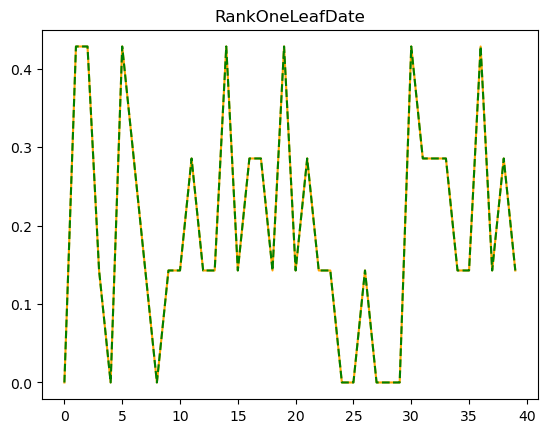

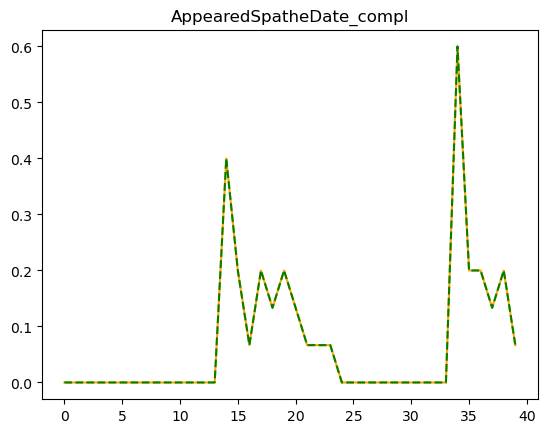

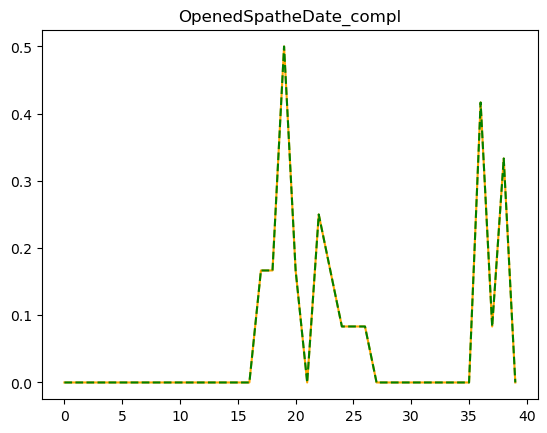

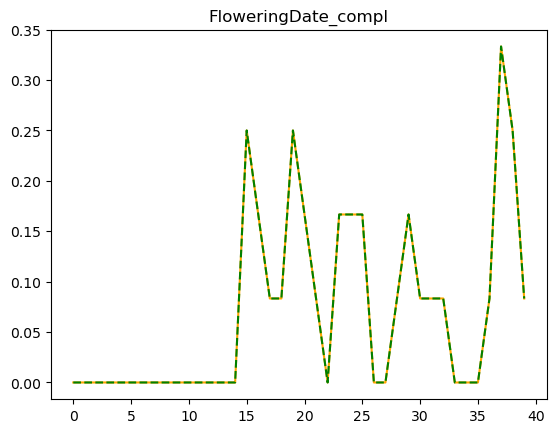

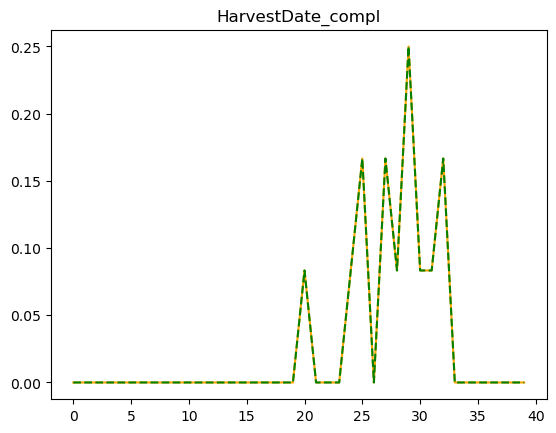

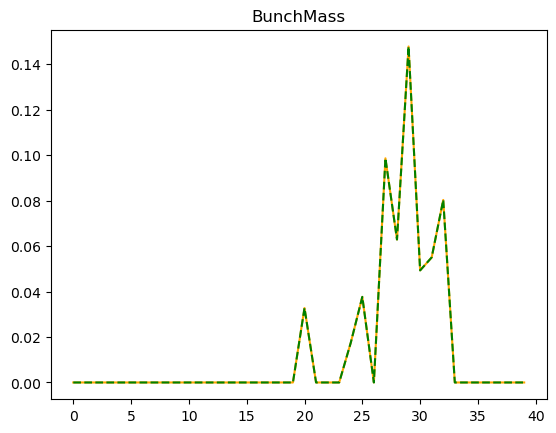

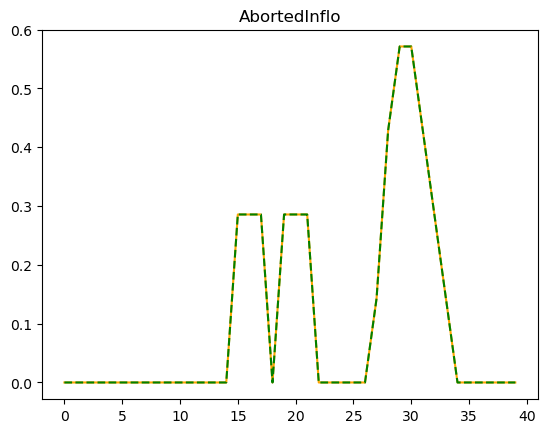

In [ ]:
for i in range(0,7):
    plt.plot(X_train_pheno_minus[2,2,:,i].reshape(-1,1), c='orange')
    plt.plot(X_train_pheno_plus[2,2,:,i].reshape(-1,1), c='green', linestyle='dashed')
    plt.title(list(VarOfInterest_Init.keys())[i])
    plt.show()

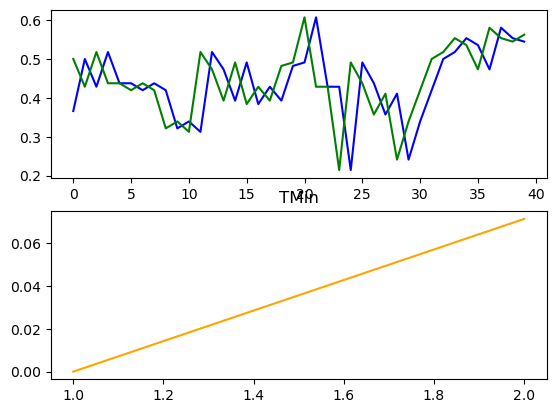

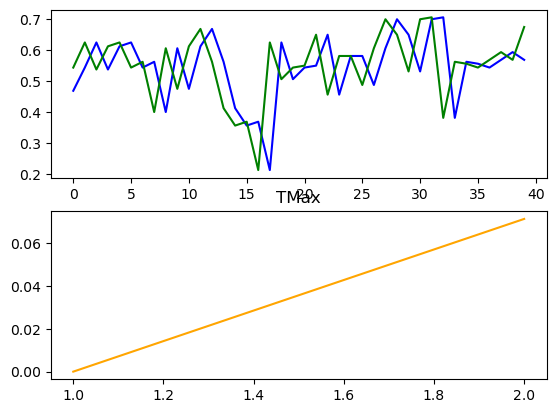

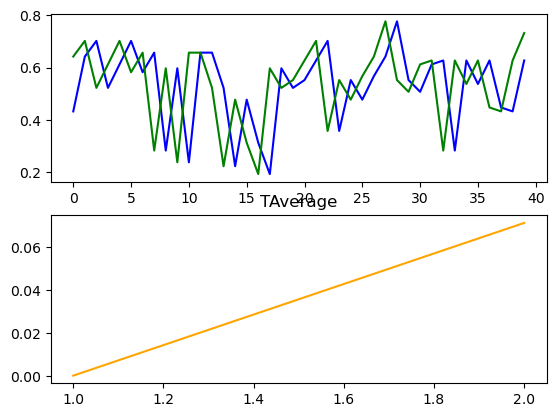

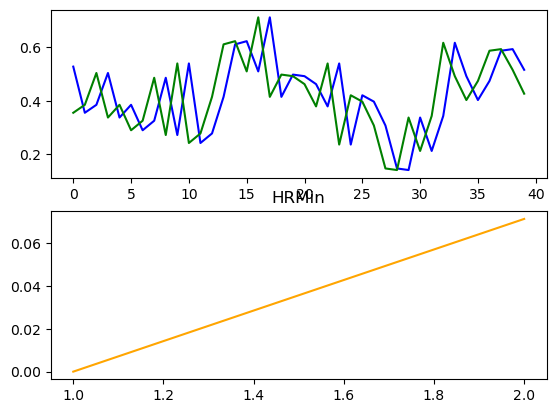

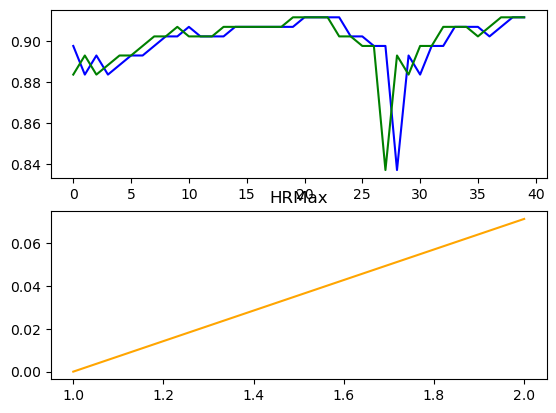

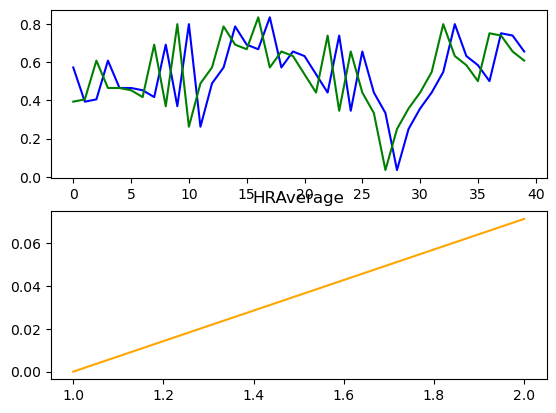

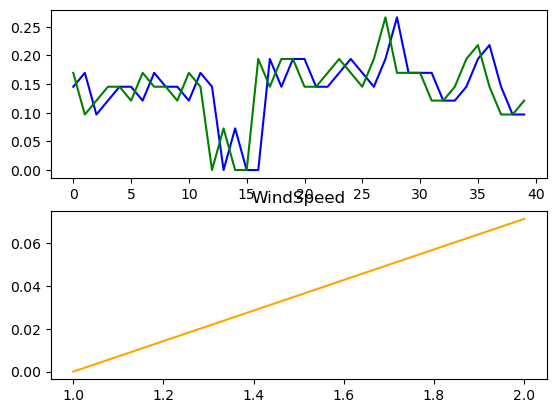

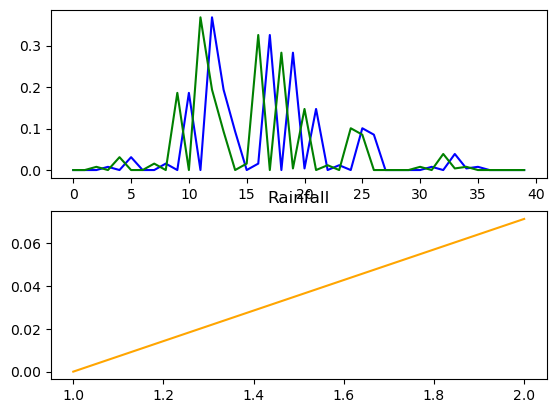

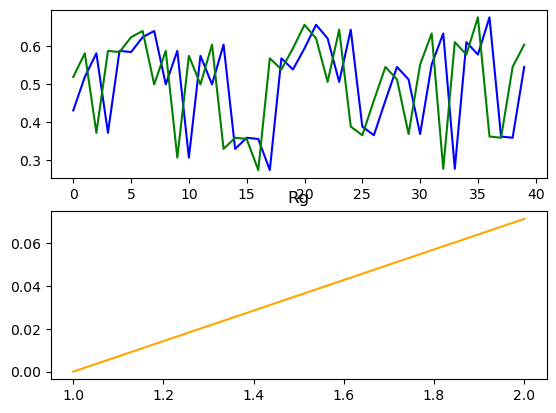

In [ ]:
for i in range(0,9):
    fig, [ax1, ax2] = plt.subplots(2)
    ax1.plot(X_test_meteo[1,1,:,i].reshape(-1,1), c='b')
    ax1.plot(X_test_meteo[1,2,:,i].reshape(-1,1), c='g')
    ax2.plot([1,2], y_test_f[1,1:3,:].reshape(-1,1), c='orange')
    plt.title(f'{MeteoVarOfInterest_Init[1:][i]}')
    plt.show()
